In [7]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor
import pandas as pd
import pickle

In [8]:
#Retrieve the data
x_train = pd.read_pickle("data/train_x.pkl")
x_val = pd.read_pickle("data/val_x.pkl")
x_test = pd.read_pickle("data/test_x.pkl")
x_nulls = pd.read_pickle("data/x_nulls.pkl")

y_train = pd.read_pickle("data/train_y.pkl")
y_val = pd.read_pickle("data/val_y.pkl")
y_test = pd.read_pickle("data/test_y.pkl")
y_nulls = pd.read_pickle("data/y_nulls.pkl")


In [9]:
#Define the desired neural network
#2 hidden-layers seems more than enough for the complexity the problem
def neural_network(x_train, x_val, y_train, y_val, decay=None, lmbda = None, neurons=256, epochs=100, batch_size=128):
    
    NN_model = Sequential()
    
    if not lmbda:
        NN_model.add(Dense(neurons, kernel_initializer='normal',input_shape=(x_train.shape[1],), activation='relu',bias_initializer='zeros'))
        NN_model.add(Dense(neurons, kernel_initializer='normal',activation='relu',bias_initializer='zeros'))
    else:
        NN_model.add(Dense(neurons, kernel_initializer='normal',input_shape=(x_train.shape[1],),
                     activation='relu', kernel_regularizer=regularizers.l2(lmbda),bias_initializer='zeros'))
        NN_model.add(Dense(neurons, kernel_initializer='normal',input_shape=(x_train.shape[1],),
                     activation='relu', kernel_regularizer=regularizers.l2(lmbda),bias_initializer='zeros'))

    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear',bias_initializer='zeros'))
    
    if decay:
        optimizer = optimizers.Adam(decay=decay)
    else:
        optimizer = optimizers.Adam()
        
    NN_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    hist = NN_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))
    return NN_model, hist

In [10]:
#Print and plot important variables
def nn_performance(x_train, y_train, x_val, y_val, NN_model, hist):
    print("Train set Mae: " , NN_model.evaluate(x_train, y_train)[1])
    print("Val set Mae: ",  NN_model.evaluate(x_val, y_val)[1])
    plt.plot(hist.history["loss"],label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.ylim(top=20)
    plt.figsize=(25,5)
    plt.legend()
    plt.show()

In [10]:
#Fit the model without decay or regularization term
NN_model, hist = neural_network(x_train, x_val, y_train, y_val)

Train on 5588 samples, validate on 1197 samples
Epoch 1/100
5588/5588 [==============================] - 1s 121us/step - loss: 71.4347 - mean_absolute_error: 71.4347 - val_loss: 46.0864 - val_mean_absolute_error: 46.0864
Epoch 2/100
5588/5588 [==============================] - 0s 88us/step - loss: 29.3932 - mean_absolute_error: 29.3932 - val_loss: 23.7170 - val_mean_absolute_error: 23.7170
Epoch 3/100
5588/5588 [==============================] - 0s 71us/step - loss: 21.2217 - mean_absolute_error: 21.2217 - val_loss: 19.1252 - val_mean_absolute_error: 19.1252
Epoch 4/100
5588/5588 [==============================] - 0s 69us/step - loss: 18.5113 - mean_absolute_error: 18.5113 - val_loss: 17.9049 - val_mean_absolute_error: 17.9049
Epoch 5/100
5588/5588 [==============================] - 0s 70us/step - loss: 17.5383 - mean_absolute_error: 17.5383 - val_loss: 17.7715 - val_mean_absolute_error: 17.7715
Epoch 6/100
5588/5588 [==============================] - 0s 71us/step - loss: 17.1197 - mea

5588/5588 [==============================] - 1s 90us/step - loss: 14.0487 - mean_absolute_error: 14.0487 - val_loss: 17.5011 - val_mean_absolute_error: 17.5011
Epoch 96/100
5588/5588 [==============================] - 0s 84us/step - loss: 14.0403 - mean_absolute_error: 14.0403 - val_loss: 17.5218 - val_mean_absolute_error: 17.5218
Epoch 97/100
5588/5588 [==============================] - 0s 70us/step - loss: 14.0799 - mean_absolute_error: 14.0799 - val_loss: 17.4782 - val_mean_absolute_error: 17.4782
Epoch 98/100
5588/5588 [==============================] - 0s 71us/step - loss: 14.0084 - mean_absolute_error: 14.0084 - val_loss: 17.5279 - val_mean_absolute_error: 17.5279
Epoch 99/100
5588/5588 [==============================] - 0s 71us/step - loss: 13.9636 - mean_absolute_error: 13.9636 - val_loss: 17.5023 - val_mean_absolute_error: 17.5023
Epoch 100/100
5588/5588 [==============================] - 0s 68us/step - loss: 13.9429 - mean_absolute_error: 13.9429 - val_loss: 17.4442 - val_mea

5588/5588 [==============================] - 0s 50us/step
Train set Mae:  13.847430229187012
1197/1197 [==============================] - 0s 48us/step
Val set Mae:  17.44424057006836


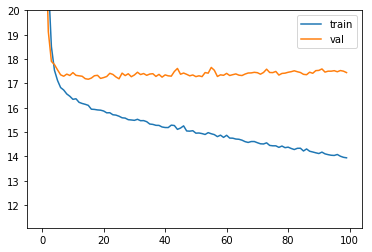

In [11]:
#We see some overfitting and a lot of movement near the optimum value
#Lets try some decay rates and then some regularization parameters
nn_performance(x_train, y_train, x_val, y_val, NN_model, hist)

In [11]:
#Define a function to find the best value for hyperparameter lambda
def tune_lmbda(lmbdas, x_train, x_val, y_train, y_val, decay=1.5e-6, neurons=256, epochs=100, batch_size=128):
    best_mae = 10000
    best_lmbda = 10000
    best_model = None
    maes = []
    
    for lmbda in lmbdas:
        model, hist = neural_network(x_train, x_val, y_train, y_val, decay=decay, lmbda = lmbda,
                                                  neurons=neurons, epochs=epochs, batch_size=batch_size)
        mae_val = model.evaluate(x_val, y_val)[1]
        maes.append(mae_val)
        if mae_val < best_mae:
            best_mae = mae_val
            best_lmbda = lmbda
            best_model = model
    return best_mae, best_lmbda, best_model, maes

In [13]:
#Fit the model
NN_model, hist = neural_network(x_train, x_val, y_train, y_val, decay=1.5e-6, epochs=250)

Train on 5588 samples, validate on 1197 samples
Epoch 1/250
5588/5588 [==============================] - 1s 100us/step - loss: 72.7807 - mean_absolute_error: 72.7807 - val_loss: 50.3630 - val_mean_absolute_error: 50.3630
Epoch 2/250
5588/5588 [==============================] - 0s 69us/step - loss: 30.2145 - mean_absolute_error: 30.2145 - val_loss: 23.4871 - val_mean_absolute_error: 23.4871
Epoch 3/250
5588/5588 [==============================] - 0s 69us/step - loss: 21.1757 - mean_absolute_error: 21.1757 - val_loss: 19.0619 - val_mean_absolute_error: 19.0619
Epoch 4/250
5588/5588 [==============================] - 0s 68us/step - loss: 18.4111 - mean_absolute_error: 18.4111 - val_loss: 17.8774 - val_mean_absolute_error: 17.8774
Epoch 5/250
5588/5588 [==============================] - 0s 69us/step - loss: 17.5018 - mean_absolute_error: 17.5018 - val_loss: 17.6235 - val_mean_absolute_error: 17.6235
Epoch 6/250
5588/5588 [==============================] - 0s 70us/step - loss: 17.0985 - mea

5588/5588 [==============================] - 0s 65us/step - loss: 14.2295 - mean_absolute_error: 14.2295 - val_loss: 17.5226 - val_mean_absolute_error: 17.5226
Epoch 96/250
5588/5588 [==============================] - 0s 65us/step - loss: 14.2045 - mean_absolute_error: 14.2045 - val_loss: 17.3969 - val_mean_absolute_error: 17.3969
Epoch 97/250
5588/5588 [==============================] - 0s 67us/step - loss: 14.2377 - mean_absolute_error: 14.2377 - val_loss: 17.5230 - val_mean_absolute_error: 17.5230
Epoch 98/250
5588/5588 [==============================] - 0s 69us/step - loss: 14.2111 - mean_absolute_error: 14.2111 - val_loss: 17.4588 - val_mean_absolute_error: 17.4588
Epoch 99/250
5588/5588 [==============================] - 0s 69us/step - loss: 14.2008 - mean_absolute_error: 14.2008 - val_loss: 17.4542 - val_mean_absolute_error: 17.4542
Epoch 100/250
5588/5588 [==============================] - 0s 71us/step - loss: 14.1236 - mean_absolute_error: 14.1236 - val_loss: 17.4387 - val_mea

5588/5588 [==============================] - 0s 79us/step - loss: 12.2540 - mean_absolute_error: 12.2540 - val_loss: 18.0829 - val_mean_absolute_error: 18.0829
Epoch 190/250
5588/5588 [==============================] - 0s 72us/step - loss: 12.2343 - mean_absolute_error: 12.2343 - val_loss: 18.0534 - val_mean_absolute_error: 18.0534
Epoch 191/250
5588/5588 [==============================] - 0s 83us/step - loss: 12.2633 - mean_absolute_error: 12.2633 - val_loss: 18.4571 - val_mean_absolute_error: 18.4571
Epoch 192/250
5588/5588 [==============================] - 0s 80us/step - loss: 12.2362 - mean_absolute_error: 12.2362 - val_loss: 18.0388 - val_mean_absolute_error: 18.0388
Epoch 193/250
5588/5588 [==============================] - 0s 83us/step - loss: 12.1330 - mean_absolute_error: 12.1330 - val_loss: 18.0368 - val_mean_absolute_error: 18.0368
Epoch 194/250
5588/5588 [==============================] - 0s 66us/step - loss: 12.0932 - mean_absolute_error: 12.0932 - val_loss: 18.1356 - val

5588/5588 [==============================] - 0s 44us/step
Train set Mae:  10.928672790527344
1197/1197 [==============================] - 0s 53us/step
Val set Mae:  18.526613235473633


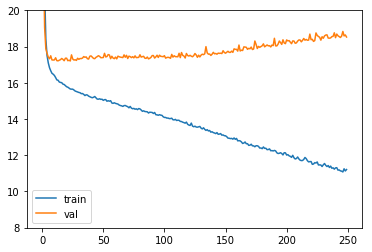

In [14]:
#Seems a bit better.  Now lets reduce overfitting by adding a regularization term
nn_performance(x_train, y_train, x_val, y_val, NN_model, hist)

In [15]:
#Fit model on a set of lambdas, and the refine the search near the optima
#Takes a lot of time
lmbdas = [10**(-i) for i in range(1,10)]
best_mae, best_lmbda, best_model, maes = tune_lmbda(lmbdas, x_train, x_val, y_train, y_val, epochs = 300)

Train on 5588 samples, validate on 1197 samples
Epoch 1/300
5588/5588 [==============================] - 1s 104us/step - loss: 104.3325 - mean_absolute_error: 78.0409 - val_loss: 83.6568 - val_mean_absolute_error: 69.9249
Epoch 2/300
5588/5588 [==============================] - 0s 71us/step - loss: 54.4742 - mean_absolute_error: 39.9845 - val_loss: 38.7405 - val_mean_absolute_error: 27.4494
Epoch 3/300
5588/5588 [==============================] - 0s 72us/step - loss: 33.6419 - mean_absolute_error: 24.1807 - val_loss: 28.9515 - val_mean_absolute_error: 20.9713
Epoch 4/300
5588/5588 [==============================] - 0s 73us/step - loss: 27.4730 - mean_absolute_error: 20.3724 - val_loss: 25.1404 - val_mean_absolute_error: 18.7862
Epoch 5/300
5588/5588 [==============================] - 0s 73us/step - loss: 24.7275 - mean_absolute_error: 18.9495 - val_loss: 23.9005 - val_mean_absolute_error: 18.8871
Epoch 6/300
5588/5588 [==============================] - 0s 73us/step - loss: 23.3275 - me

5588/5588 [==============================] - 0s 72us/step - loss: 18.8483 - mean_absolute_error: 17.7008 - val_loss: 18.6118 - val_mean_absolute_error: 17.4296
Epoch 96/300
5588/5588 [==============================] - 0s 70us/step - loss: 19.0901 - mean_absolute_error: 17.9484 - val_loss: 18.8559 - val_mean_absolute_error: 17.6215
Epoch 97/300
5588/5588 [==============================] - 0s 71us/step - loss: 18.9072 - mean_absolute_error: 17.7345 - val_loss: 19.0491 - val_mean_absolute_error: 17.9519
Epoch 98/300
5588/5588 [==============================] - 0s 73us/step - loss: 18.8407 - mean_absolute_error: 17.7066 - val_loss: 18.5691 - val_mean_absolute_error: 17.4711
Epoch 99/300
5588/5588 [==============================] - 0s 74us/step - loss: 18.8279 - mean_absolute_error: 17.6796 - val_loss: 19.1552 - val_mean_absolute_error: 18.0965
Epoch 100/300
5588/5588 [==============================] - 0s 75us/step - loss: 18.8055 - mean_absolute_error: 17.6977 - val_loss: 18.6395 - val_mea

5588/5588 [==============================] - 0s 70us/step - loss: 18.2241 - mean_absolute_error: 17.1736 - val_loss: 18.3218 - val_mean_absolute_error: 17.3176
Epoch 190/300
5588/5588 [==============================] - 0s 68us/step - loss: 18.2738 - mean_absolute_error: 17.2538 - val_loss: 18.1856 - val_mean_absolute_error: 17.1668
Epoch 191/300
5588/5588 [==============================] - 0s 69us/step - loss: 18.2368 - mean_absolute_error: 17.1872 - val_loss: 18.1013 - val_mean_absolute_error: 17.0519
Epoch 192/300
5588/5588 [==============================] - 0s 69us/step - loss: 18.2044 - mean_absolute_error: 17.1637 - val_loss: 18.1099 - val_mean_absolute_error: 17.0929
Epoch 193/300
5588/5588 [==============================] - 0s 69us/step - loss: 18.1985 - mean_absolute_error: 17.1904 - val_loss: 18.0574 - val_mean_absolute_error: 17.0456
Epoch 194/300
5588/5588 [==============================] - 0s 69us/step - loss: 18.2665 - mean_absolute_error: 17.2295 - val_loss: 18.1166 - val

Epoch 283/300
5588/5588 [==============================] - 0s 70us/step - loss: 17.8713 - mean_absolute_error: 16.9367 - val_loss: 17.8887 - val_mean_absolute_error: 16.9508
Epoch 284/300
5588/5588 [==============================] - 0s 74us/step - loss: 17.9417 - mean_absolute_error: 17.0174 - val_loss: 17.9711 - val_mean_absolute_error: 17.0813
Epoch 285/300
5588/5588 [==============================] - 0s 81us/step - loss: 17.9275 - mean_absolute_error: 17.0112 - val_loss: 17.8807 - val_mean_absolute_error: 16.9568
Epoch 286/300
5588/5588 [==============================] - 0s 69us/step - loss: 17.8686 - mean_absolute_error: 16.9689 - val_loss: 17.8691 - val_mean_absolute_error: 16.9301
Epoch 287/300
5588/5588 [==============================] - 0s 69us/step - loss: 17.8961 - mean_absolute_error: 16.9645 - val_loss: 17.9578 - val_mean_absolute_error: 17.0481
Epoch 288/300
5588/5588 [==============================] - 0s 69us/step - loss: 17.8884 - mean_absolute_error: 16.9637 - val_loss:

Epoch 30/300
5588/5588 [==============================] - 1s 90us/step - loss: 17.8765 - mean_absolute_error: 16.8651 - val_loss: 17.9668 - val_mean_absolute_error: 16.9553
Epoch 31/300
5588/5588 [==============================] - 0s 73us/step - loss: 17.8349 - mean_absolute_error: 16.8327 - val_loss: 18.0096 - val_mean_absolute_error: 17.0168
Epoch 32/300
5588/5588 [==============================] - 0s 82us/step - loss: 17.7732 - mean_absolute_error: 16.7790 - val_loss: 18.0127 - val_mean_absolute_error: 17.0147
Epoch 33/300
5588/5588 [==============================] - 0s 69us/step - loss: 17.7426 - mean_absolute_error: 16.7666 - val_loss: 18.0269 - val_mean_absolute_error: 17.0535
Epoch 34/300
5588/5588 [==============================] - 0s 70us/step - loss: 17.7787 - mean_absolute_error: 16.8079 - val_loss: 18.1076 - val_mean_absolute_error: 17.1225
Epoch 35/300
5588/5588 [==============================] - 0s 70us/step - loss: 17.7337 - mean_absolute_error: 16.7724 - val_loss: 18.00

5588/5588 [==============================] - 0s 77us/step - loss: 16.6757 - mean_absolute_error: 15.7545 - val_loss: 18.5105 - val_mean_absolute_error: 17.6057
Epoch 125/300
5588/5588 [==============================] - 1s 95us/step - loss: 16.7089 - mean_absolute_error: 15.7785 - val_loss: 18.1810 - val_mean_absolute_error: 17.2538
Epoch 126/300
5588/5588 [==============================] - 0s 75us/step - loss: 16.6434 - mean_absolute_error: 15.7069 - val_loss: 18.1915 - val_mean_absolute_error: 17.2562
Epoch 127/300
5588/5588 [==============================] - 0s 72us/step - loss: 16.5916 - mean_absolute_error: 15.6526 - val_loss: 17.9286 - val_mean_absolute_error: 16.9792
Epoch 128/300
5588/5588 [==============================] - 0s 71us/step - loss: 16.6006 - mean_absolute_error: 15.6511 - val_loss: 18.0044 - val_mean_absolute_error: 17.0485
Epoch 129/300
5588/5588 [==============================] - 0s 69us/step - loss: 16.6221 - mean_absolute_error: 15.6714 - val_loss: 18.0530 - val

5588/5588 [==============================] - 0s 67us/step - loss: 15.6234 - mean_absolute_error: 14.3731 - val_loss: 18.4482 - val_mean_absolute_error: 17.1968
Epoch 219/300
5588/5588 [==============================] - 0s 67us/step - loss: 15.6793 - mean_absolute_error: 14.4285 - val_loss: 18.4488 - val_mean_absolute_error: 17.1972
Epoch 220/300
5588/5588 [==============================] - 0s 67us/step - loss: 15.6542 - mean_absolute_error: 14.3990 - val_loss: 18.5813 - val_mean_absolute_error: 17.3222
Epoch 221/300
5588/5588 [==============================] - 0s 67us/step - loss: 15.6263 - mean_absolute_error: 14.3653 - val_loss: 18.4659 - val_mean_absolute_error: 17.2038
Epoch 222/300
5588/5588 [==============================] - 0s 67us/step - loss: 15.6586 - mean_absolute_error: 14.4004 - val_loss: 18.4872 - val_mean_absolute_error: 17.2283
Epoch 223/300
5588/5588 [==============================] - 0s 67us/step - loss: 15.5876 - mean_absolute_error: 14.3191 - val_loss: 18.5427 - val

Epoch 12/300
5588/5588 [==============================] - 0s 70us/step - loss: 16.9273 - mean_absolute_error: 16.4150 - val_loss: 17.6683 - val_mean_absolute_error: 17.1521
Epoch 13/300
5588/5588 [==============================] - 0s 71us/step - loss: 16.8316 - mean_absolute_error: 16.3128 - val_loss: 17.7360 - val_mean_absolute_error: 17.2175
Epoch 14/300
5588/5588 [==============================] - 0s 69us/step - loss: 16.7797 - mean_absolute_error: 16.2579 - val_loss: 17.7017 - val_mean_absolute_error: 17.1738
Epoch 15/300
5588/5588 [==============================] - 0s 69us/step - loss: 16.7614 - mean_absolute_error: 16.2341 - val_loss: 17.6553 - val_mean_absolute_error: 17.1225
Epoch 16/300
5588/5588 [==============================] - 0s 69us/step - loss: 16.7639 - mean_absolute_error: 16.2303 - val_loss: 17.8541 - val_mean_absolute_error: 17.3233
Epoch 17/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.6397 - mean_absolute_error: 16.1031 - val_loss: 17.64

5588/5588 [==============================] - 0s 75us/step - loss: 14.0243 - mean_absolute_error: 13.3124 - val_loss: 18.3972 - val_mean_absolute_error: 17.6878
Epoch 107/300
5588/5588 [==============================] - 0s 70us/step - loss: 13.8758 - mean_absolute_error: 13.1650 - val_loss: 18.4848 - val_mean_absolute_error: 17.7748
Epoch 108/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.9303 - mean_absolute_error: 13.2173 - val_loss: 18.3388 - val_mean_absolute_error: 17.6243
Epoch 109/300
5588/5588 [==============================] - 0s 70us/step - loss: 13.8997 - mean_absolute_error: 13.1847 - val_loss: 18.5604 - val_mean_absolute_error: 17.8466
Epoch 110/300
5588/5588 [==============================] - 0s 73us/step - loss: 13.9840 - mean_absolute_error: 13.2698 - val_loss: 18.4188 - val_mean_absolute_error: 17.7053
Epoch 111/300
5588/5588 [==============================] - 0s 78us/step - loss: 13.9723 - mean_absolute_error: 13.2573 - val_loss: 18.3841 - val

5588/5588 [==============================] - 0s 73us/step - loss: 12.5008 - mean_absolute_error: 11.6930 - val_loss: 19.1950 - val_mean_absolute_error: 18.3874
Epoch 201/300
5588/5588 [==============================] - 0s 80us/step - loss: 12.4101 - mean_absolute_error: 11.6000 - val_loss: 19.3247 - val_mean_absolute_error: 18.5125
Epoch 202/300
5588/5588 [==============================] - 0s 69us/step - loss: 12.5012 - mean_absolute_error: 11.6912 - val_loss: 19.3250 - val_mean_absolute_error: 18.5170
Epoch 203/300
5588/5588 [==============================] - 0s 69us/step - loss: 12.3923 - mean_absolute_error: 11.5826 - val_loss: 19.2678 - val_mean_absolute_error: 18.4580
Epoch 204/300
5588/5588 [==============================] - 0s 70us/step - loss: 12.4523 - mean_absolute_error: 11.6407 - val_loss: 19.2789 - val_mean_absolute_error: 18.4658
Epoch 205/300
5588/5588 [==============================] - 0s 71us/step - loss: 12.3769 - mean_absolute_error: 11.5631 - val_loss: 19.3249 - val

5588/5588 [==============================] - 0s 69us/step - loss: 11.4880 - mean_absolute_error: 10.5623 - val_loss: 20.0192 - val_mean_absolute_error: 19.0929
Epoch 295/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.3091 - mean_absolute_error: 10.3814 - val_loss: 20.1155 - val_mean_absolute_error: 19.1878
Epoch 296/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.4781 - mean_absolute_error: 10.5502 - val_loss: 20.1439 - val_mean_absolute_error: 19.2151
Epoch 297/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.5952 - mean_absolute_error: 10.6656 - val_loss: 20.1134 - val_mean_absolute_error: 19.1833
Epoch 298/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.4394 - mean_absolute_error: 10.5084 - val_loss: 20.1411 - val_mean_absolute_error: 19.2105
Epoch 299/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.2734 - mean_absolute_error: 10.3417 - val_loss: 20.0359 - val

Epoch 41/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.2571 - mean_absolute_error: 15.1314 - val_loss: 17.5587 - val_mean_absolute_error: 17.4326
Epoch 42/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.1847 - mean_absolute_error: 15.0580 - val_loss: 17.4197 - val_mean_absolute_error: 17.2930
Epoch 43/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.1600 - mean_absolute_error: 15.0325 - val_loss: 17.3011 - val_mean_absolute_error: 17.1727
Epoch 44/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.1242 - mean_absolute_error: 14.9953 - val_loss: 17.4344 - val_mean_absolute_error: 17.3050
Epoch 45/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.1397 - mean_absolute_error: 15.0096 - val_loss: 17.4047 - val_mean_absolute_error: 17.2738
Epoch 46/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.1258 - mean_absolute_error: 14.9945 - val_loss: 17.38

5588/5588 [==============================] - 0s 69us/step - loss: 12.7688 - mean_absolute_error: 12.5872 - val_loss: 17.9345 - val_mean_absolute_error: 17.7524
Epoch 136/300
5588/5588 [==============================] - 0s 68us/step - loss: 12.7247 - mean_absolute_error: 12.5427 - val_loss: 17.9207 - val_mean_absolute_error: 17.7384
Epoch 137/300
5588/5588 [==============================] - 0s 68us/step - loss: 12.7468 - mean_absolute_error: 12.5645 - val_loss: 17.9109 - val_mean_absolute_error: 17.7284
Epoch 138/300
5588/5588 [==============================] - 0s 67us/step - loss: 12.8039 - mean_absolute_error: 12.6214 - val_loss: 17.8829 - val_mean_absolute_error: 17.7000
Epoch 139/300
5588/5588 [==============================] - 0s 68us/step - loss: 12.7667 - mean_absolute_error: 12.5836 - val_loss: 17.8946 - val_mean_absolute_error: 17.7113
Epoch 140/300
5588/5588 [==============================] - 0s 70us/step - loss: 12.6621 - mean_absolute_error: 12.4785 - val_loss: 17.8957 - val

Epoch 229/300
5588/5588 [==============================] - 0s 68us/step - loss: 10.9495 - mean_absolute_error: 10.7281 - val_loss: 18.7408 - val_mean_absolute_error: 18.5192
Epoch 230/300
5588/5588 [==============================] - 0s 67us/step - loss: 11.0001 - mean_absolute_error: 10.7784 - val_loss: 18.8114 - val_mean_absolute_error: 18.5896
Epoch 231/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.0189 - mean_absolute_error: 10.7968 - val_loss: 18.8848 - val_mean_absolute_error: 18.6626
Epoch 232/300
5588/5588 [==============================] - 0s 67us/step - loss: 10.9716 - mean_absolute_error: 10.7494 - val_loss: 18.8621 - val_mean_absolute_error: 18.6398
Epoch 233/300
5588/5588 [==============================] - 0s 67us/step - loss: 11.0155 - mean_absolute_error: 10.7929 - val_loss: 18.7126 - val_mean_absolute_error: 18.4900
Epoch 234/300
5588/5588 [==============================] - 0s 67us/step - loss: 10.9880 - mean_absolute_error: 10.7652 - val_loss:

Epoch 23/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.7443 - mean_absolute_error: 15.7332 - val_loss: 17.4612 - val_mean_absolute_error: 17.4500
Epoch 24/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.6862 - mean_absolute_error: 15.6749 - val_loss: 17.3166 - val_mean_absolute_error: 17.3052
Epoch 25/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.7241 - mean_absolute_error: 15.7127 - val_loss: 17.5138 - val_mean_absolute_error: 17.5023
Epoch 26/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.6707 - mean_absolute_error: 15.6591 - val_loss: 17.2738 - val_mean_absolute_error: 17.2621
Epoch 27/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.5880 - mean_absolute_error: 15.5762 - val_loss: 17.4230 - val_mean_absolute_error: 17.4111
Epoch 28/300
5588/5588 [==============================] - 0s 68us/step - loss: 15.6816 - mean_absolute_error: 15.6695 - val_loss: 17.28

5588/5588 [==============================] - 0s 75us/step - loss: 13.2489 - mean_absolute_error: 13.2259 - val_loss: 17.6856 - val_mean_absolute_error: 17.6625
Epoch 118/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.2385 - mean_absolute_error: 13.2154 - val_loss: 17.6916 - val_mean_absolute_error: 17.6685
Epoch 119/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.2408 - mean_absolute_error: 13.2176 - val_loss: 17.6948 - val_mean_absolute_error: 17.6714
Epoch 120/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.1626 - mean_absolute_error: 13.1392 - val_loss: 17.6127 - val_mean_absolute_error: 17.5893
Epoch 121/300
5588/5588 [==============================] - 0s 70us/step - loss: 13.1341 - mean_absolute_error: 13.1107 - val_loss: 17.7202 - val_mean_absolute_error: 17.6968
Epoch 122/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.1819 - mean_absolute_error: 13.1584 - val_loss: 17.7994 - val

5588/5588 [==============================] - 0s 69us/step - loss: 11.2662 - mean_absolute_error: 11.2353 - val_loss: 18.7580 - val_mean_absolute_error: 18.7272
Epoch 212/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.4230 - mean_absolute_error: 11.3921 - val_loss: 18.7667 - val_mean_absolute_error: 18.7358
Epoch 213/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.1928 - mean_absolute_error: 11.1619 - val_loss: 18.7462 - val_mean_absolute_error: 18.7152
Epoch 214/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.1986 - mean_absolute_error: 11.1676 - val_loss: 18.7828 - val_mean_absolute_error: 18.7517
Epoch 215/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.1747 - mean_absolute_error: 11.1436 - val_loss: 18.5398 - val_mean_absolute_error: 18.5086
Epoch 216/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.0692 - mean_absolute_error: 11.0380 - val_loss: 18.6040 - val

5588/5588 [==============================] - 0s 69us/step - loss: 18.4934 - mean_absolute_error: 18.4927 - val_loss: 17.8445 - val_mean_absolute_error: 17.8438
Epoch 5/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.5880 - mean_absolute_error: 17.5873 - val_loss: 17.5799 - val_mean_absolute_error: 17.5792
Epoch 6/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.1195 - mean_absolute_error: 17.1187 - val_loss: 17.5168 - val_mean_absolute_error: 17.5161
Epoch 7/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.9082 - mean_absolute_error: 16.9075 - val_loss: 17.3942 - val_mean_absolute_error: 17.3935
Epoch 8/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.6671 - mean_absolute_error: 16.6664 - val_loss: 17.2410 - val_mean_absolute_error: 17.2402
Epoch 9/300
5588/5588 [==============================] - 0s 69us/step - loss: 16.5280 - mean_absolute_error: 16.5272 - val_loss: 17.2456 - val_mean_abso

5588/5588 [==============================] - 0s 70us/step - loss: 13.7981 - mean_absolute_error: 13.7959 - val_loss: 17.3025 - val_mean_absolute_error: 17.3003
Epoch 99/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.8050 - mean_absolute_error: 13.8028 - val_loss: 17.2794 - val_mean_absolute_error: 17.2772
Epoch 100/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.7476 - mean_absolute_error: 13.7453 - val_loss: 17.3122 - val_mean_absolute_error: 17.3099
Epoch 101/300
5588/5588 [==============================] - 0s 67us/step - loss: 13.7451 - mean_absolute_error: 13.7428 - val_loss: 17.3298 - val_mean_absolute_error: 17.3276
Epoch 102/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.7001 - mean_absolute_error: 13.6978 - val_loss: 17.2615 - val_mean_absolute_error: 17.2592
Epoch 103/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.7198 - mean_absolute_error: 13.7175 - val_loss: 17.3022 - val_

5588/5588 [==============================] - 0s 71us/step - loss: 11.8573 - mean_absolute_error: 11.8541 - val_loss: 18.1054 - val_mean_absolute_error: 18.1022
Epoch 193/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.7402 - mean_absolute_error: 11.7371 - val_loss: 18.2552 - val_mean_absolute_error: 18.2520
Epoch 194/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.8067 - mean_absolute_error: 11.8035 - val_loss: 18.2860 - val_mean_absolute_error: 18.2828
Epoch 195/300
5588/5588 [==============================] - 0s 68us/step - loss: 11.7153 - mean_absolute_error: 11.7121 - val_loss: 18.2179 - val_mean_absolute_error: 18.2147
Epoch 196/300
5588/5588 [==============================] - 0s 72us/step - loss: 11.7174 - mean_absolute_error: 11.7142 - val_loss: 18.2640 - val_mean_absolute_error: 18.2607
Epoch 197/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.7264 - mean_absolute_error: 11.7232 - val_loss: 18.2570 - val

5588/5588 [==============================] - 0s 69us/step - loss: 10.2298 - mean_absolute_error: 10.2259 - val_loss: 18.9812 - val_mean_absolute_error: 18.9773
Epoch 287/300
5588/5588 [==============================] - 0s 69us/step - loss: 10.2986 - mean_absolute_error: 10.2947 - val_loss: 19.0107 - val_mean_absolute_error: 19.0068
Epoch 288/300
5588/5588 [==============================] - 0s 68us/step - loss: 10.2477 - mean_absolute_error: 10.2438 - val_loss: 19.0979 - val_mean_absolute_error: 19.0940
Epoch 289/300
5588/5588 [==============================] - 0s 68us/step - loss: 10.2739 - mean_absolute_error: 10.2700 - val_loss: 19.2198 - val_mean_absolute_error: 19.2159
Epoch 290/300
5588/5588 [==============================] - 0s 69us/step - loss: 10.3815 - mean_absolute_error: 10.3776 - val_loss: 19.1856 - val_mean_absolute_error: 19.1817
Epoch 291/300
5588/5588 [==============================] - 0s 70us/step - loss: 10.1907 - mean_absolute_error: 10.1867 - val_loss: 19.0685 - val

Epoch 33/300
5588/5588 [==============================] - 0s 71us/step - loss: 15.3907 - mean_absolute_error: 15.3905 - val_loss: 17.3555 - val_mean_absolute_error: 17.3554
Epoch 34/300
5588/5588 [==============================] - 0s 70us/step - loss: 15.3772 - mean_absolute_error: 15.3770 - val_loss: 17.2994 - val_mean_absolute_error: 17.2993
Epoch 35/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.3729 - mean_absolute_error: 15.3728 - val_loss: 17.6171 - val_mean_absolute_error: 17.6170
Epoch 36/300
5588/5588 [==============================] - 0s 70us/step - loss: 15.3602 - mean_absolute_error: 15.3601 - val_loss: 17.3214 - val_mean_absolute_error: 17.3212
Epoch 37/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.2912 - mean_absolute_error: 15.2911 - val_loss: 17.3653 - val_mean_absolute_error: 17.3652
Epoch 38/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.2804 - mean_absolute_error: 15.2802 - val_loss: 17.49

5588/5588 [==============================] - 0s 70us/step - loss: 13.1049 - mean_absolute_error: 13.1046 - val_loss: 17.5564 - val_mean_absolute_error: 17.5561
Epoch 128/300
5588/5588 [==============================] - 0s 68us/step - loss: 13.1867 - mean_absolute_error: 13.1864 - val_loss: 17.5542 - val_mean_absolute_error: 17.5540
Epoch 129/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.2143 - mean_absolute_error: 13.2141 - val_loss: 17.6461 - val_mean_absolute_error: 17.6458
Epoch 130/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.1148 - mean_absolute_error: 13.1146 - val_loss: 17.8345 - val_mean_absolute_error: 17.8342
Epoch 131/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.1546 - mean_absolute_error: 13.1543 - val_loss: 17.6662 - val_mean_absolute_error: 17.6659
Epoch 132/300
5588/5588 [==============================] - 0s 71us/step - loss: 13.1406 - mean_absolute_error: 13.1403 - val_loss: 17.4958 - val

5588/5588 [==============================] - 0s 70us/step - loss: 11.2571 - mean_absolute_error: 11.2568 - val_loss: 18.3705 - val_mean_absolute_error: 18.3702
Epoch 222/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.1296 - mean_absolute_error: 11.1293 - val_loss: 18.4889 - val_mean_absolute_error: 18.4886
Epoch 223/300
5588/5588 [==============================] - 0s 70us/step - loss: 11.2320 - mean_absolute_error: 11.2317 - val_loss: 18.5253 - val_mean_absolute_error: 18.5250
Epoch 224/300
5588/5588 [==============================] - 0s 71us/step - loss: 11.1655 - mean_absolute_error: 11.1651 - val_loss: 18.4043 - val_mean_absolute_error: 18.4040
Epoch 225/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.2941 - mean_absolute_error: 11.2937 - val_loss: 18.3972 - val_mean_absolute_error: 18.3969
Epoch 226/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.1352 - mean_absolute_error: 11.1349 - val_loss: 18.3976 - val

Epoch 15/300
5588/5588 [==============================] - 0s 72us/step - loss: 16.0465 - mean_absolute_error: 16.0465 - val_loss: 17.3205 - val_mean_absolute_error: 17.3205
Epoch 16/300
5588/5588 [==============================] - 0s 72us/step - loss: 15.9999 - mean_absolute_error: 15.9999 - val_loss: 17.2167 - val_mean_absolute_error: 17.2167
Epoch 17/300
5588/5588 [==============================] - 0s 71us/step - loss: 15.9250 - mean_absolute_error: 15.9250 - val_loss: 17.2646 - val_mean_absolute_error: 17.2646
Epoch 18/300
5588/5588 [==============================] - 0s 71us/step - loss: 15.8787 - mean_absolute_error: 15.8787 - val_loss: 17.2336 - val_mean_absolute_error: 17.2336
Epoch 19/300
5588/5588 [==============================] - 0s 71us/step - loss: 15.8863 - mean_absolute_error: 15.8863 - val_loss: 17.3181 - val_mean_absolute_error: 17.3181
Epoch 20/300
5588/5588 [==============================] - 0s 72us/step - loss: 15.8450 - mean_absolute_error: 15.8450 - val_loss: 17.26

5588/5588 [==============================] - 0s 81us/step - loss: 14.0986 - mean_absolute_error: 14.0985 - val_loss: 17.4713 - val_mean_absolute_error: 17.4713
Epoch 110/300
5588/5588 [==============================] - 0s 73us/step - loss: 14.0968 - mean_absolute_error: 14.0968 - val_loss: 17.7490 - val_mean_absolute_error: 17.7490
Epoch 111/300
5588/5588 [==============================] - 0s 73us/step - loss: 14.2105 - mean_absolute_error: 14.2105 - val_loss: 17.4875 - val_mean_absolute_error: 17.4874
Epoch 112/300
5588/5588 [==============================] - 1s 100us/step - loss: 14.1596 - mean_absolute_error: 14.1596 - val_loss: 17.5526 - val_mean_absolute_error: 17.5526
Epoch 113/300
5588/5588 [==============================] - 1s 104us/step - loss: 14.1290 - mean_absolute_error: 14.1290 - val_loss: 17.5113 - val_mean_absolute_error: 17.5113
Epoch 114/300
5588/5588 [==============================] - 1s 100us/step - loss: 13.9835 - mean_absolute_error: 13.9835 - val_loss: 17.5111 - 

5588/5588 [==============================] - 0s 72us/step - loss: 12.0942 - mean_absolute_error: 12.0941 - val_loss: 18.2822 - val_mean_absolute_error: 18.2821
Epoch 204/300
5588/5588 [==============================] - 0s 72us/step - loss: 12.1110 - mean_absolute_error: 12.1110 - val_loss: 18.2785 - val_mean_absolute_error: 18.2785
Epoch 205/300
5588/5588 [==============================] - 0s 71us/step - loss: 12.0542 - mean_absolute_error: 12.0541 - val_loss: 18.2769 - val_mean_absolute_error: 18.2768
Epoch 206/300
5588/5588 [==============================] - 0s 71us/step - loss: 12.0202 - mean_absolute_error: 12.0202 - val_loss: 18.1873 - val_mean_absolute_error: 18.1872
Epoch 207/300
5588/5588 [==============================] - 0s 71us/step - loss: 11.9299 - mean_absolute_error: 11.9298 - val_loss: 18.2130 - val_mean_absolute_error: 18.2130
Epoch 208/300
5588/5588 [==============================] - 0s 71us/step - loss: 11.9630 - mean_absolute_error: 11.9629 - val_loss: 18.2499 - val

5588/5588 [==============================] - 0s 72us/step - loss: 10.3038 - mean_absolute_error: 10.3037 - val_loss: 19.3553 - val_mean_absolute_error: 19.3552
Epoch 298/300
5588/5588 [==============================] - 0s 71us/step - loss: 10.1208 - mean_absolute_error: 10.1208 - val_loss: 19.0955 - val_mean_absolute_error: 19.0955
Epoch 299/300
5588/5588 [==============================] - 0s 72us/step - loss: 10.2279 - mean_absolute_error: 10.2279 - val_loss: 19.0900 - val_mean_absolute_error: 19.0900
Epoch 300/300
1197/1197 [==============================] - 0s 60us/step
Train on 5588 samples, validate on 1197 samples
Epoch 1/300
5588/5588 [==============================] - 1s 107us/step - loss: 71.1047 - mean_absolute_error: 71.1047 - val_loss: 45.3614 - val_mean_absolute_error: 45.3614
Epoch 2/300
5588/5588 [==============================] - 0s 72us/step - loss: 29.6482 - mean_absolute_error: 29.6482 - val_loss: 23.7600 - val_mean_absolute_error: 23.7600
Epoch 3/300
5588/5588 [====

Epoch 44/300
5588/5588 [==============================] - 0s 70us/step - loss: 15.1988 - mean_absolute_error: 15.1988 - val_loss: 17.3736 - val_mean_absolute_error: 17.3736
Epoch 45/300
5588/5588 [==============================] - 0s 70us/step - loss: 15.1696 - mean_absolute_error: 15.1696 - val_loss: 17.3780 - val_mean_absolute_error: 17.3780
Epoch 46/300
5588/5588 [==============================] - 0s 69us/step - loss: 15.1140 - mean_absolute_error: 15.1140 - val_loss: 17.3509 - val_mean_absolute_error: 17.3509
Epoch 47/300
5588/5588 [==============================] - 0s 70us/step - loss: 15.1285 - mean_absolute_error: 15.1285 - val_loss: 17.3835 - val_mean_absolute_error: 17.3835
Epoch 48/300
5588/5588 [==============================] - 0s 87us/step - loss: 15.1487 - mean_absolute_error: 15.1487 - val_loss: 17.4297 - val_mean_absolute_error: 17.4297
Epoch 49/300
5588/5588 [==============================] - 0s 71us/step - loss: 15.0869 - mean_absolute_error: 15.0869 - val_loss: 17.41

5588/5588 [==============================] - 0s 70us/step - loss: 13.3539 - mean_absolute_error: 13.3539 - val_loss: 17.6120 - val_mean_absolute_error: 17.6120
Epoch 139/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.3470 - mean_absolute_error: 13.3470 - val_loss: 17.6070 - val_mean_absolute_error: 17.6070
Epoch 140/300
5588/5588 [==============================] - 0s 70us/step - loss: 13.3520 - mean_absolute_error: 13.3520 - val_loss: 17.7490 - val_mean_absolute_error: 17.7490
Epoch 141/300
5588/5588 [==============================] - 0s 70us/step - loss: 13.3037 - mean_absolute_error: 13.3037 - val_loss: 17.5886 - val_mean_absolute_error: 17.5886
Epoch 142/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.2855 - mean_absolute_error: 13.2855 - val_loss: 17.6076 - val_mean_absolute_error: 17.6076
Epoch 143/300
5588/5588 [==============================] - 0s 69us/step - loss: 13.2628 - mean_absolute_error: 13.2628 - val_loss: 17.6081 - val

5588/5588 [==============================] - 0s 70us/step - loss: 11.3420 - mean_absolute_error: 11.3420 - val_loss: 18.6031 - val_mean_absolute_error: 18.6031
Epoch 233/300
5588/5588 [==============================] - 0s 70us/step - loss: 11.2995 - mean_absolute_error: 11.2995 - val_loss: 18.4553 - val_mean_absolute_error: 18.4553
Epoch 234/300
5588/5588 [==============================] - 0s 70us/step - loss: 11.3371 - mean_absolute_error: 11.3371 - val_loss: 18.5279 - val_mean_absolute_error: 18.5279
Epoch 235/300
5588/5588 [==============================] - 0s 69us/step - loss: 11.3206 - mean_absolute_error: 11.3206 - val_loss: 18.6427 - val_mean_absolute_error: 18.6427
Epoch 236/300
5588/5588 [==============================] - 0s 71us/step - loss: 11.3007 - mean_absolute_error: 11.3007 - val_loss: 18.6685 - val_mean_absolute_error: 18.6685
Epoch 237/300
5588/5588 [==============================] - 0s 83us/step - loss: 11.4053 - mean_absolute_error: 11.4053 - val_loss: 18.5165 - val

In [16]:
#0.1 is the best value so far.  There is stil some overfitting, so lets try some values between 0.3 and 0.01
print("Best lambda: ", best_lmbda)
print("Train set Mae: " , best_model.evaluate(x_train, y_train)[1])
print("Best mae in val set: ", best_mae)
[print(lmbdas[i], maes[i]) for i in range(len(maes))]

Best lambda:  0.1
5588/5588 [==============================] - 0s 72us/step
Train set Mae:  16.927881240844727
Best mae in val set:  17.222667694091797
0.1 17.222667694091797
0.01 17.582658767700195
0.001 19.316259384155273
0.0001 19.464279174804688
1e-05 19.262792587280273
1e-06 19.159162521362305
1e-07 18.953689575195312
1e-08 19.1331787109375
1e-09 19.018966674804688


[None, None, None, None, None, None, None, None, None]

In [34]:
lmbdas = [10**(-i/10) for i in range(4,20,2)]
# print(lmbdas)
best_mae, best_lmbda, best_model, maes = tune_lmbda(lmbdas, x_train, x_val, y_train, y_val, epochs = 300)

[0.3981071705534972, 0.251188643150958, 0.15848931924611134, 0.1, 0.06309573444801933, 0.039810717055349734, 0.025118864315095794, 0.015848931924611134]


In [33]:
#Both train and val set errors decrease, so lets refine the search one last time
print("Best lambda: ", best_lmbda)
print("Train set Mae: " , best_model.evaluate(x_train, y_train)[1])
print("Best mae in val set: ", best_mae)
[print(lmbdas[i], maes[i]) for i in range(len(maes))]

Best lambda:  0.025118864315095794
5588/5588 [==============================] - 0s 53us/step
Train set Mae:  15.476079940795898
Best mae in val set:  16.895633697509766
0.3981071705534972 17.384782791137695
0.251188643150958 17.306442260742188
0.15848931924611134 17.128257751464844
0.1 16.930233001708984
0.06309573444801933 16.958648681640625
0.039810717055349734 17.02121925354004
0.025118864315095794 16.895633697509766
0.015848931924611134 17.222164154052734


[None, None, None, None, None, None, None, None]

In [14]:
lmbdas = [10**(-i/100) for i in range(145,180,5)]
best_mae, best_lmbda, best_model, maes = tune_lmbda(lmbdas, x_train, x_val, y_train, y_val, epochs = 300)

Train on 5588 samples, validate on 1197 samples
Epoch 1/300
5588/5588 [==============================] - 1s 137us/step - loss: 83.9832 - mean_absolute_error: 74.9694 - val_loss: 63.7516 - val_mean_absolute_error: 57.4845
Epoch 2/300
5588/5588 [==============================] - 0s 73us/step - loss: 40.0263 - mean_absolute_error: 32.9272 - val_loss: 31.2426 - val_mean_absolute_error: 25.2047
Epoch 3/300
5588/5588 [==============================] - 0s 70us/step - loss: 28.1693 - mean_absolute_error: 22.5584 - val_loss: 25.1049 - val_mean_absolute_error: 20.0433
Epoch 4/300
5588/5588 [==============================] - 0s 70us/step - loss: 24.1947 - mean_absolute_error: 19.5264 - val_loss: 22.5307 - val_mean_absolute_error: 18.1562
Epoch 5/300
5588/5588 [==============================] - 0s 70us/step - loss: 22.4066 - mean_absolute_error: 18.3509 - val_loss: 21.4819 - val_mean_absolute_error: 17.6272
Epoch 6/300
5588/5588 [==============================] - 0s 70us/step - loss: 21.4767 - mea

5588/5588 [==============================] - 0s 68us/step - loss: 17.7669 - mean_absolute_error: 16.8767 - val_loss: 18.0740 - val_mean_absolute_error: 17.1993
Epoch 96/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.7544 - mean_absolute_error: 16.8672 - val_loss: 17.8937 - val_mean_absolute_error: 17.0045
Epoch 97/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.7720 - mean_absolute_error: 16.8735 - val_loss: 18.1415 - val_mean_absolute_error: 17.2563
Epoch 98/300
5588/5588 [==============================] - 0s 68us/step - loss: 18.0593 - mean_absolute_error: 17.1543 - val_loss: 18.0941 - val_mean_absolute_error: 17.2241
Epoch 99/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.8154 - mean_absolute_error: 16.9309 - val_loss: 18.1805 - val_mean_absolute_error: 17.3062
Epoch 100/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.7872 - mean_absolute_error: 16.9077 - val_loss: 18.0678 - val_mea

5588/5588 [==============================] - 0s 69us/step - loss: 17.3115 - mean_absolute_error: 16.4652 - val_loss: 17.6728 - val_mean_absolute_error: 16.8322
Epoch 190/300
5588/5588 [==============================] - 0s 70us/step - loss: 17.2818 - mean_absolute_error: 16.4461 - val_loss: 17.7528 - val_mean_absolute_error: 16.9194
Epoch 191/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.3265 - mean_absolute_error: 16.4823 - val_loss: 17.9536 - val_mean_absolute_error: 17.1287
Epoch 192/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.3514 - mean_absolute_error: 16.5296 - val_loss: 17.7943 - val_mean_absolute_error: 16.9809
Epoch 193/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.3646 - mean_absolute_error: 16.5374 - val_loss: 17.7907 - val_mean_absolute_error: 16.9451
Epoch 194/300
5588/5588 [==============================] - 0s 69us/step - loss: 17.3817 - mean_absolute_error: 16.5583 - val_loss: 17.7525 - val

5588/5588 [==============================] - 0s 69us/step - loss: 16.9915 - mean_absolute_error: 16.1363 - val_loss: 17.7520 - val_mean_absolute_error: 16.8956
Epoch 284/300
5588/5588 [==============================] - 0s 68us/step - loss: 17.0012 - mean_absolute_error: 16.1520 - val_loss: 17.8281 - val_mean_absolute_error: 16.9928
Epoch 285/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.9518 - mean_absolute_error: 16.1088 - val_loss: 17.8549 - val_mean_absolute_error: 17.0133
Epoch 286/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.9531 - mean_absolute_error: 16.1085 - val_loss: 17.7139 - val_mean_absolute_error: 16.8627
Epoch 287/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.9483 - mean_absolute_error: 16.0962 - val_loss: 17.7265 - val_mean_absolute_error: 16.8783
Epoch 288/300
5588/5588 [==============================] - 0s 68us/step - loss: 16.9623 - mean_absolute_error: 16.1134 - val_loss: 17.6980 - val

In [15]:
print("Best lambda: ", best_lmbda)
print("Train set Mae: " , best_model.evaluate(x_train, y_train)[1])
print("Best mae in val set: ", best_mae)
[print(lmbdas[i], maes[i]) for i in range(len(maes))]

Best lambda:  0.03162277660168379
5588/5588 [==============================] - 0s 56us/step
Train set Mae:  15.937986373901367
Best mae in val set:  16.867616653442383
0.03162277660168379 16.867616653442383


[None]

In [16]:
#The final reported error is 16.87
#This model beats linear regression, but just by a little.
#Maybe the relationship of the variables is linear, or perhaps we need more data for such complex models
print("Test set Mae: " , best_model.evaluate(x_test, y_test)[1])

1198/1198 [==============================] - 0s 64us/step
Test set Mae:  16.873254776000977


In [17]:
#Dump the predictions
with open("predictions/DNN.csv", "w") as f:
    predictions = best_model.predict(x_nulls)
    [f.write("{}, {}\n".format(i,j)) for (i,j) in zip(y_nulls.order_id, predictions)]

In [20]:
#Dump the model
pickle.dump(best_model, open("models_dump/DNN.sav", 'wb'))